In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import correlate as cross_corr
from scipy.signal import periodogram

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use("Theoretical Neuroscience.mplstyle")


In [2]:
# Plotting Functions

def plot_tuning_function(f):
  ori_sample = np.arange(-90, 90, 1)
  firing_sample = f(ori_sample)
  plt.plot(ori_sample, firing_sample, 'k')
  plt.xlabel('Stimulus Orientation (deg)')
  plt.ylabel('Firing Rate (Hz)')
  plt.ylim([0, 60])
  plt.xlim([-80,80])
  plt.show()

def plot_s_fr(t, stimulus, firing_rate):
  fig, ax = plt.subplots(2, 1, figsize=(8, 6))
  ax[0].plot(t, stimulus, 'k')
  ax[0].set_ylabel('Stimulus Orientation (deg)')
  ax[0].set_ylim([-60, 60])
  ax[0].set_yticks(np.arange(-60,61,20))
  ax[0].set_xlim([0, 500])
  ax[1].set_ylabel("Average Firing Rate (Hz)")
  ax[1].plot(t,firing_rate, 'k')
  ax[1].set_ylim([0, 60])
  ax[1].set_yticks(np.arange(0, 61,20))
  ax[1].set_xlabel("Time (ms)")
  ax[1].set_xlim([0, 500])
  plt.show()

def plot_spikes(T, spike_trains, n_trains):
  for i in range(n_trains):
    plt.eventplot(np.argwhere(spike_trains[i]).T,lineoffsets=i, linelengths=0.5, colors=[0,0,0])
  plt.xlabel("Time (ms)")
  plt.xlim([0,T])
  plt.ylabel("Spikes")
  plt.yticks(np.arange(0, n_trains, 1))
  plt.show()

def plot_empirical_fr(t, spike_trains):
  plt.plot(t,np.mean(spike_trains,axis=0)*1000, 'k')
  plt.ylabel("Empirical Firing Rate (Hz)")
  plt.ylim([0, 60])
  plt.yticks(np.arange(0, 61,20))
  plt.xlabel("Time (ms)")
  plt.xlim([0, 500])
  plt.show()

def plot_ISI_Fano(ISI, mean_sc, var_sc):
  fig, ax = plt.subplots(1, 2, figsize=(8, 4))
  ax[0].hist(ISI, bins=20, color='gray', edgecolor='black', density=True)
  ax[0].set_ylabel('ISI density')
  ax[0].set_xlabel("Interspike Interval (ms)")
  ax[1].scatter(mean_sc,var_sc,color='k')
  ax[1].set_ylabel("Variance Spikes")
  ax[1].set_xlabel("Mean Spikes")
  ax[1].axline([0, 0], [1, 1], color='r')
  plt.show()

def plot_autocorr(time, auto_corr):
  plt.plot(time, auto_corr,color='k')
  plt.xlim([-100, 100])
  plt.xlabel("Time (ms)")
  plt.ylabel("Auto-correlation")

In [3]:
# Record Settings
dt = 1  # 1ms
T = 500 # 500ms
t = np.arange(0, T, dt)


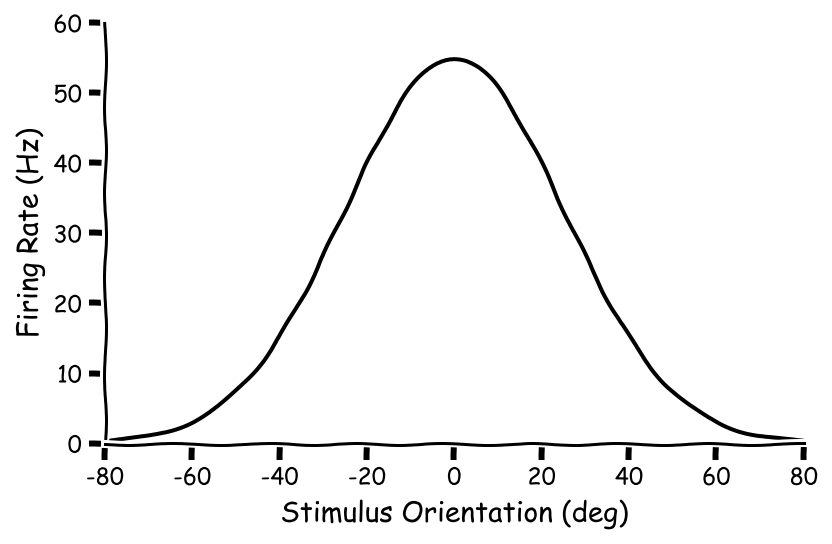

In [4]:
# Gaussian tuning function, see equation (1.14)
rmax=55
smax=0
sigmaf=25
tuning_function=lambda s: rmax*np.exp(-0.5*(s-smax)**2/sigmaf**2)
with plt.xkcd():
        plot_tuning_function(tuning_function)

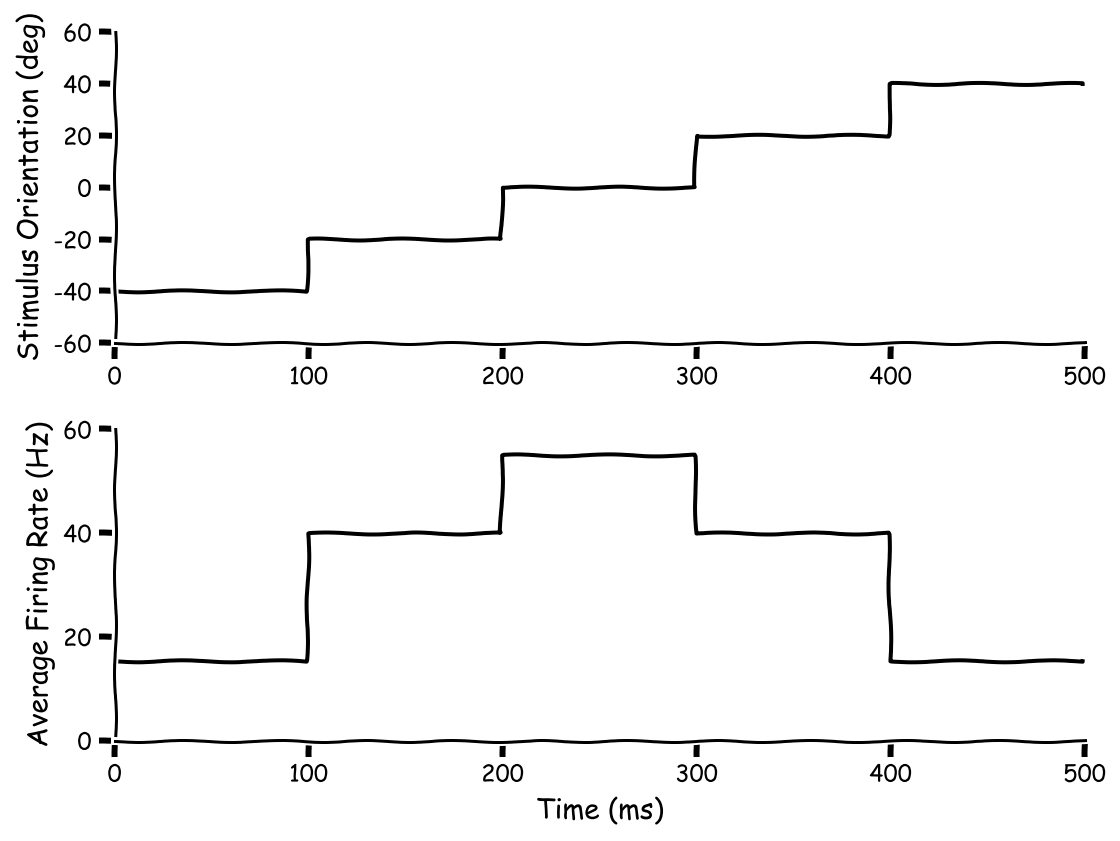

In [5]:
# Stimuli
stimulus=np.array([-40, -20, 0, 20, 40]).repeat(len(t)//5)
fr = tuning_function(stimulus)
with plt.xkcd():
    plot_s_fr(t,stimulus, fr)

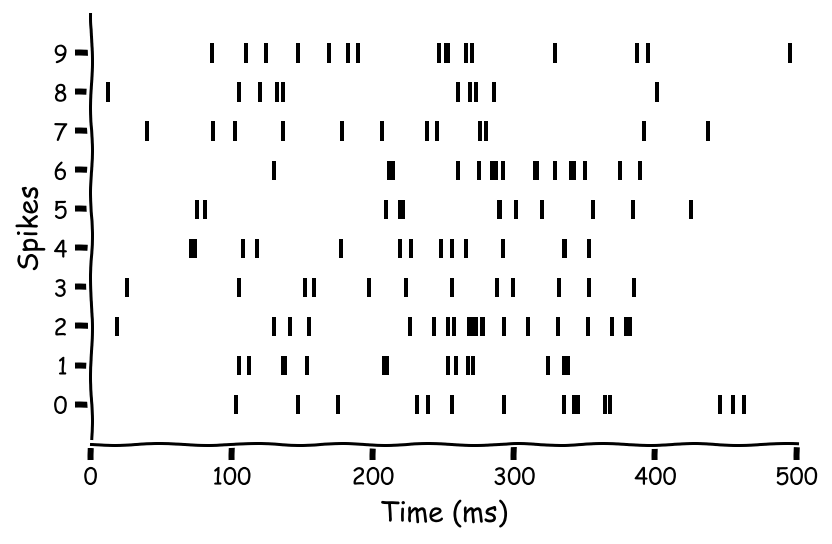

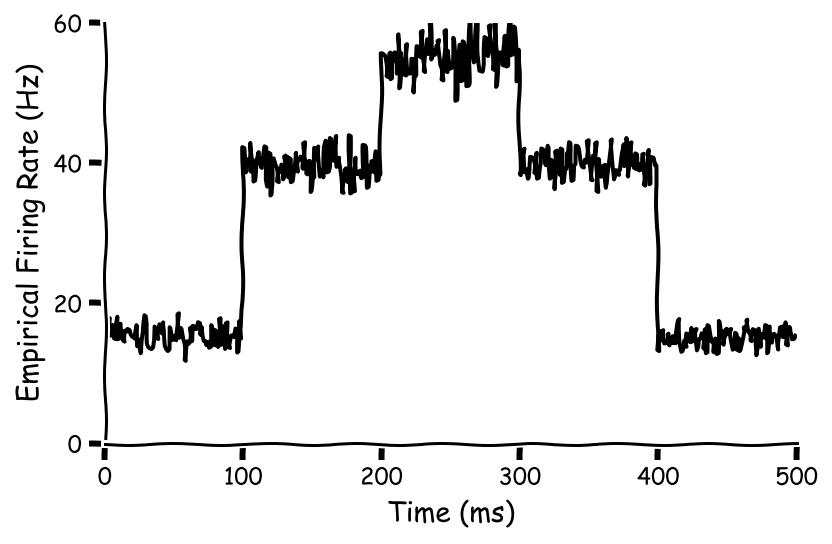

In [6]:
n_trains = 10000
p_spike = fr*dt/1000
spike_trains = (rng.random(size=(n_trains, len(t))) < p_spike).astype(np.uint8)
with plt.xkcd():
    plot_spikes(T,spike_trains, n_trains=10)
    plot_empirical_fr(t, spike_trains)

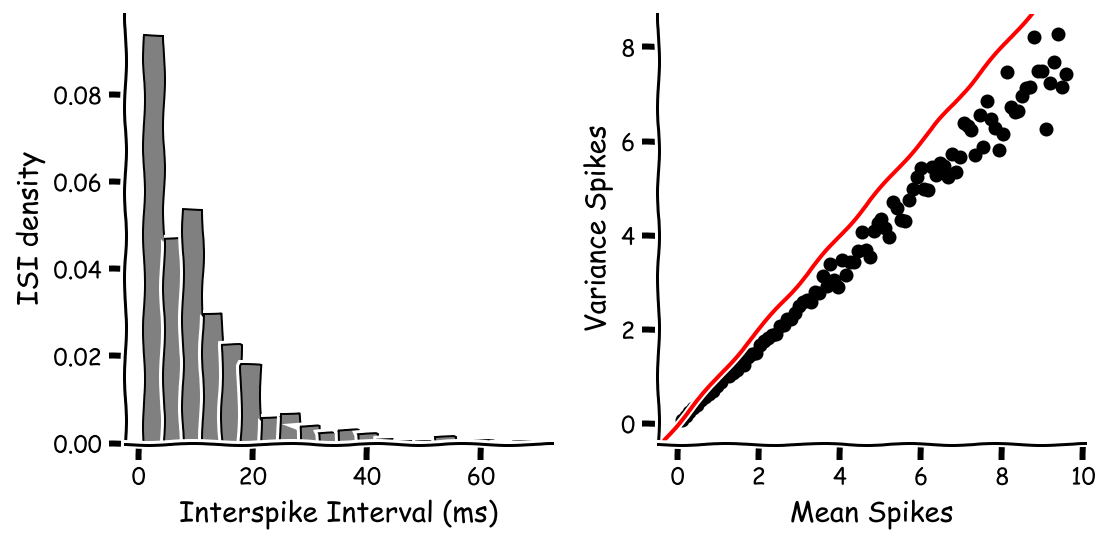

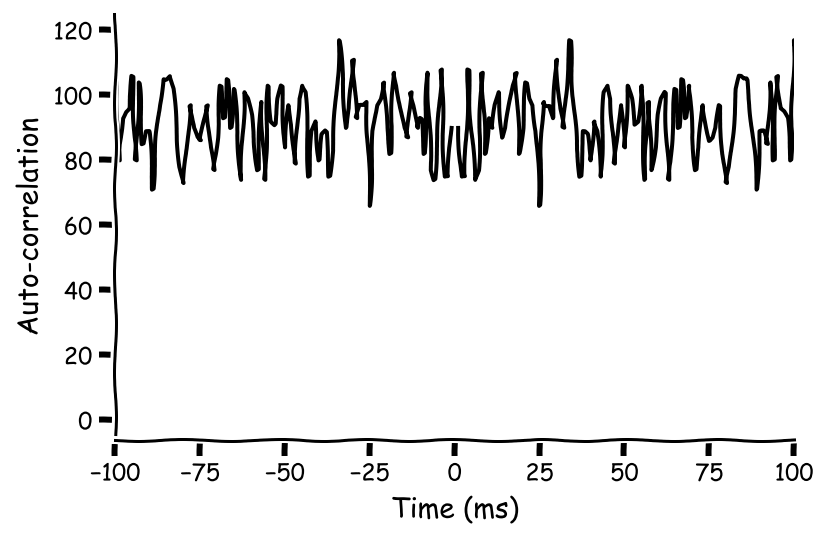

In [7]:
dt = 1  
T = 10000
t = np.arange(0, T, dt)
fr = 100
p_spike = fr*dt/1000
spike_train = (rng.random(size=len(t)) < p_spike).astype(np.uint8)
spike_event = np.argwhere(spike_train).squeeze()
ISI = np.diff(spike_event)*dt

interval = 100
mean_sc, var_sc = [], []
for bin_size in np.arange(1,interval,1):
    spike_count = spike_train[:len(t)//bin_size*bin_size].reshape(-1,bin_size).sum(axis=1)
    mean_sc.append(np.mean(spike_count,axis=0))
    var_sc.append(np.var(spike_count,axis=0))
with plt.xkcd():
    plot_ISI_Fano(ISI,mean_sc,var_sc)

time = np.arange(-T+dt,T,dt)
auto_corr = cross_corr(spike_train, spike_train).astype(np.float64)
auto_corr[len(t)-1] = np.nan
with plt.xkcd():
    plot_autocorr(time, auto_corr)

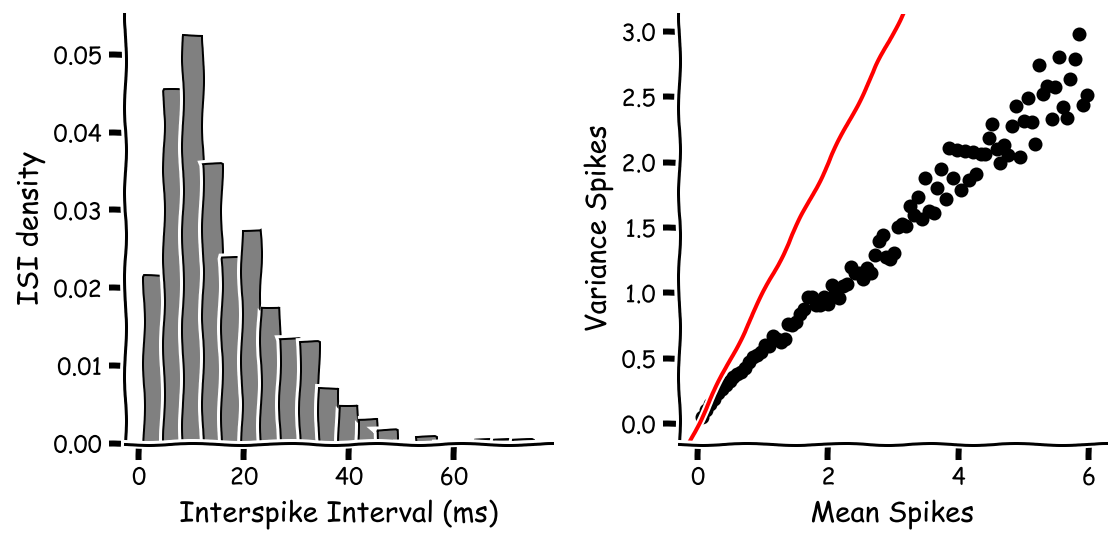

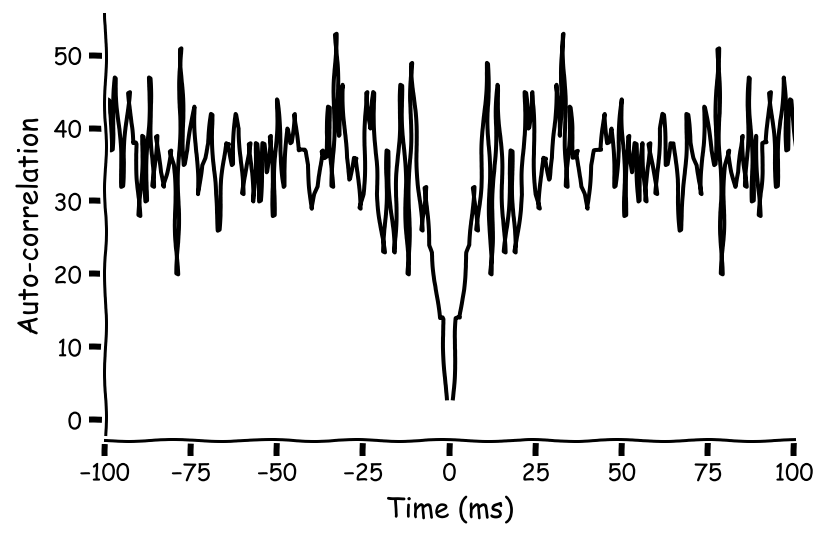

In [8]:
dt = 1  
T = 10000
t = np.arange(0, T, dt)
fr = 100
p0 = fr*dt/1000
spike_train = np.full(len(t),np.nan)
tau = 10
p = p0
for i in range(len(t)):
    deltap = (p0-p)/tau*dt
    p += deltap
    spike = rng.random() < p
    spike_train[i] = int(spike)
    if spike:
        p = 0

spike_event = np.argwhere(spike_train).squeeze()
ISI = np.diff(spike_event)*dt

interval = 100
mean_sc, var_sc = [], []
for bin_size in np.arange(1,interval,1):
    spike_count = spike_train[:len(t)//bin_size*bin_size].reshape(-1,bin_size).sum(axis=1)
    mean_sc.append(np.mean(spike_count,axis=0))
    var_sc.append(np.var(spike_count,axis=0))
with plt.xkcd():
    plot_ISI_Fano(ISI,mean_sc,var_sc)

time = np.arange(-T+dt,T,dt)
auto_corr = cross_corr(spike_train, spike_train).astype(np.float64)
auto_corr[len(t)-1] = np.nan
with plt.xkcd():
    plot_autocorr(time, auto_corr)

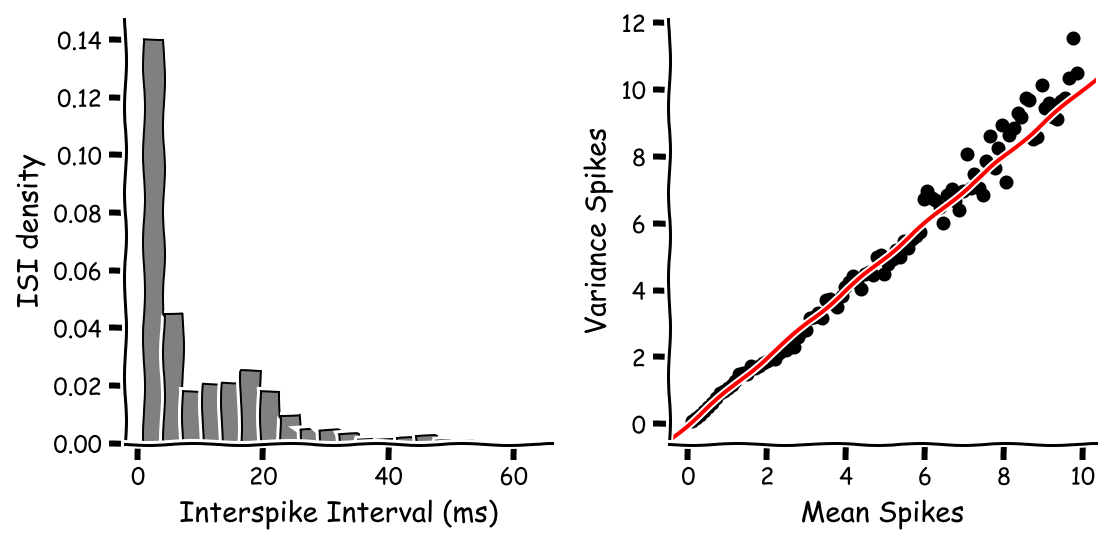

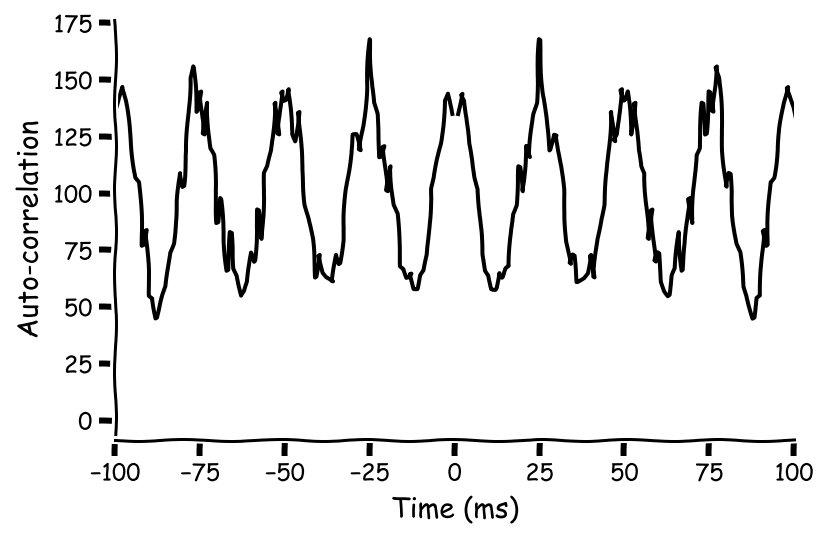

In [9]:
dt = 1  
T = 10000
t = np.arange(0, T, dt)
fr = 100*(1+np.cos(2*np.pi*t/25))
p_spike = fr*dt/1000
spike_train = (rng.random(size=len(t)) < p_spike).astype(np.uint8)
spike_event = np.argwhere(spike_train).squeeze()
ISI = np.diff(spike_event)*dt

interval = 100
mean_sc, var_sc = [], []
for bin_size in np.arange(1,interval,1):
    spike_count = spike_train[:len(t)//bin_size*bin_size].reshape(-1,bin_size).sum(axis=1)
    mean_sc.append(np.mean(spike_count,axis=0))
    var_sc.append(np.var(spike_count,axis=0))
with plt.xkcd():
    plot_ISI_Fano(ISI,mean_sc,var_sc)

time = np.arange(-T+dt,T,dt)
auto_corr = cross_corr(spike_train, spike_train).astype(np.float64)
auto_corr[len(t)-1] = np.nan
with plt.xkcd():
    plot_autocorr(time, auto_corr)

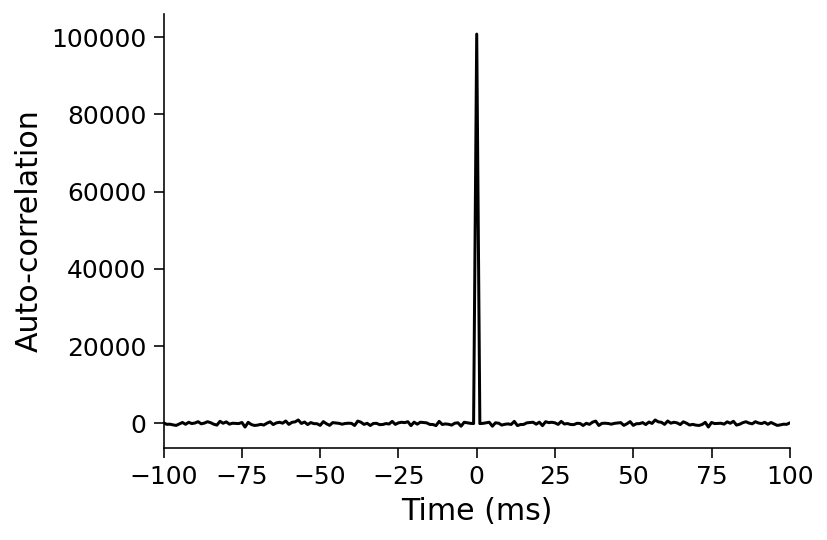

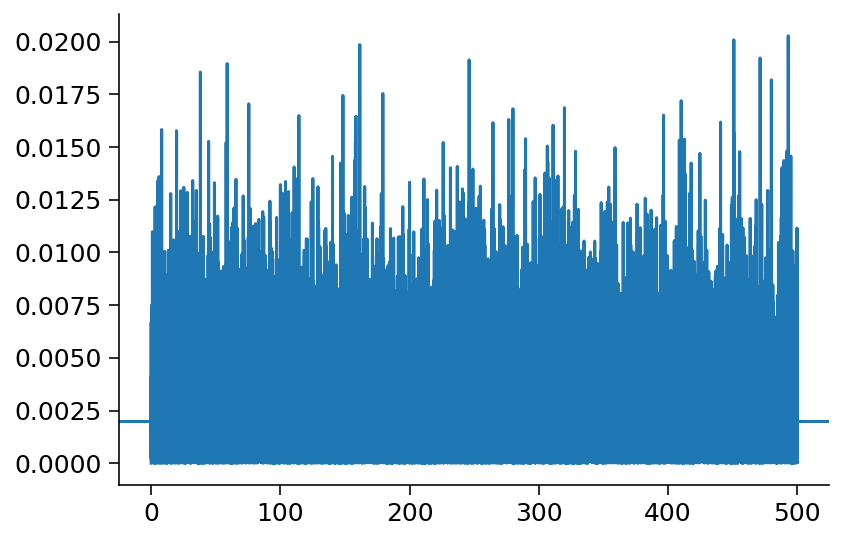

In [25]:
dt = 1  
T = 100000
t = np.arange(0, T, dt)
white_noise = rng.normal(scale=1/dt,size=t.shape)
# plt.plot(white_noise)
time = np.arange(-T+dt,T,dt)
auto_corr = cross_corr(white_noise, white_noise).astype(np.float64)
# auto_corr[len(t)-1] = np.nan
plot_autocorr(time, auto_corr)
plt.show()
f, psd = periodogram(white_noise, fs=1/dt*1000)
plt.plot(f, psd)
plt.axhline(2*dt/1000)